# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import os
import gc
from pathlib import Path
from functools import lru_cache
from typing import Optional, Sequence, Union, Iterable
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
import boto3
from boto3.s3.transfer import TransferConfig
import pyarrow as pa
import pyarrow.parquet as pq
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from dotenv import load_dotenv
from IPython.display import display
import psutil
from tqdm import tqdm

load_dotenv()

True

In [2]:
DATA_DIR = Path("data")
ARTIFACTS_DIR = Path("artifacts")

RAW_FILES = {
    "tracks": DATA_DIR / "tracks.parquet",
    "catalog_names": DATA_DIR / "catalog_names.parquet",
    "events": DATA_DIR / "interactions.parquet",
}

CLEAN_FILES = {
    "items": "items.parquet",
    "events": "events.parquet",
    "catalog_names": "catalog_names.parquet",
}

SPLIT_FILES = {
    "train": "events_train.parquet",
    "test": "events_test.parquet",
}

RECS_FILES = {
    "top_popular": "top_popular.parquet",
    "personal_als": "personal_als.parquet",
    "similar": "similar.parquet",
    "ranked": "recommendations.parquet",
}

In [3]:

S3_DATA_PREFIX = "recsys/data"
S3_RECS_PREFIX = "recsys/recommendations"

K = 100
SEED = 42
SPLIT_DATE = pd.Timestamp("2022-12-16")

ALS_FACTORS = 64
ALS_ITERATIONS = 20
ALS_REGULARIZATION = 0.01
ALS_ALPHA = 40.0
ALS_BATCH_USERS = 20_000

SIMILAR_TOP_N = 20_000
SIMILAR_BATCH = 128

EDA_PERCENTILES = (0.5, 0.9, 0.99)
EDA_BINS = 80
TOP_10 = 10

TEST_DAYS = 7 

UPLOAD_TO_S3_AT_END = False

TRAIN_USERS = 80_000
POOL_MULT = 3 
TRAIN_ROWS_LIMIT = 1_200_000
BATCH_ROWS = 200_000
POS_CHUNK = 1_000_000
LABEL_DAYS = 45


In [4]:
# Parquet IO

def require_env(name: str) -> str:
    value = os.environ.get(name)
    if not value:
        raise RuntimeError(f"missing required var: {name}")
    return value

def read_parquet(path: Path) -> pd.DataFrame:
    return pd.read_parquet(path)


def save_to_parquet(
    data: Union[pd.DataFrame, Iterable[Union[pd.DataFrame, pa.Table]]],
    path: Path,
    overwrite: bool = False
) -> Path:
    path.parent.mkdir(parents=True, exist_ok=True)

    def get_file_info():
        if not path.exists():
            return None
        return {
            "size_mb": path.stat().st_size / (1024 * 1024),
            "mtime": datetime.fromtimestamp(path.stat().st_mtime)
        }

    def print_status(action: str, rows: int = 0):
        info = get_file_info()
        if info is None:
            return
        print(f"{action}: {path.name}")
        if rows > 0:
            print(f"  rows: {rows:,}")
        print(f"  size: {info['size_mb']:.2f} mb")
        print(f"  timestamp: {info['mtime']:%Y-%m-%d %H:%M:%S}")

    if path.exists() and not overwrite:
        print(f"file already exists -> skipping: {path.name}")
        print_status("current file info")
        return path

    action = "overwritten" if path.exists() else "created"
    total_rows = 0
    writer = None

    def write_table(table: pa.Table):
        nonlocal writer, total_rows
        if writer is None:
            writer = pq.ParquetWriter(str(path), table.schema, compression="snappy", use_dictionary=False, write_statistics=False)
        writer.write_table(table)
        total_rows += table.num_rows

    try:
        if isinstance(data, pd.DataFrame):
            if not data.empty:
                table = pa.Table.from_pandas(data, preserve_index=False)
                write_table(table)
        else:
            for batch in data:
                if isinstance(batch, pd.DataFrame):
                    if batch.empty:
                        continue
                    table = pa.Table.from_pandas(batch, preserve_index=False)
                elif isinstance(batch, pa.Table):
                    table = batch
                else:
                    raise ValueError("batch must be pd.DataFrame or pa.Table")
                write_table(table)

    finally:
        if writer is not None:
            writer.close()

    print_status(action, total_rows)

    return path

In [5]:
# S3 utils

_s3_transfer_config = TransferConfig(
    multipart_threshold=8 * 1024 * 1024,
    multipart_chunksize=64 * 1024 * 1024,
    max_concurrency=10,
    use_threads=True,
)

@lru_cache(maxsize=1)
def get_s3_client():
    endpoint_url = os.environ.get("S3_ENDPOINT_URL")
    return boto3.client("s3", endpoint_url=endpoint_url)

def make_s3_key(prefix: str, filename: str) -> str:
    return f"{prefix.rstrip('/')}/{filename}"

def upload_to_s3(local_path: Path, key: str, show_progress: bool = True) -> str:
    bucket_name = require_env("S3_BUCKET_NAME")
    normalized_key = key.lstrip("/")

    class ProgressPercentage:
        def __init__(self, filename):
            self._filename = filename
            self._size = filename.stat().st_size
            self._seen_so_far = 0
            self._pbar = tqdm(total=self._size, unit='B', unit_scale=True, desc=f"uploading {filename.name}")

        def __call__(self, bytes_amount):
            self._seen_so_far += bytes_amount
            self._pbar.update(bytes_amount)

        def __del__(self):
            self._pbar.close()

    extra_args = {}
    callback = ProgressPercentage(local_path) if show_progress else None

    get_s3_client().upload_file(
        Filename=str(local_path),
        Bucket=bucket_name,
        Key=normalized_key,
        ExtraArgs=extra_args,
        Callback=callback,
        Config=_s3_transfer_config,
    )
    response = get_s3_client().head_object(Bucket=bucket_name, Key=normalized_key)
    print(f"{str(local_path)} uploaded, size: {response['ContentLength']} bytes")

    return f"s3://{bucket_name}/{normalized_key}"

def download_from_s3(key: str, local_path: Path, *, min_bytes: int = 1) -> Path:
    bucket_name = require_env("S3_BUCKET_NAME")
    normalized_key = key.lstrip("/")
    local_path.parent.mkdir(parents=True, exist_ok=True)
    get_s3_client().download_file(bucket_name, normalized_key, str(local_path))
    if local_path.stat().st_size < min_bytes:
        raise RuntimeError(f"file too small: {local_path}")
    return local_path

def read_cached_or_download(filename: str, s3_prefix: str) -> pd.DataFrame:
    local_path = ARTIFACTS_DIR / filename
    if not local_path.exists() or local_path.stat().st_size < 1:
        s3_key = make_s3_key(s3_prefix, filename)
        download_from_s3(s3_key, local_path, min_bytes=1)
    return read_parquet(local_path)

def maybe_upload(local_path: Path, s3_prefix: str, filename: str) -> None:
    if not UPLOAD_TO_S3_AT_END:
        return
    s3_key = make_s3_key(s3_prefix, filename)
    upload_to_s3(local_path, s3_key)

In [6]:
# EDA utils
def df_info(df, name: str = "df", dup_subset: Optional[Sequence] = None):
    print(f"\n{'='*3} {name.upper()} {'='*3}")
    print(f"shape: {df.shape[0]:,} x {df.shape[1]}")
    print(f"index: {type(df.index).__name__} | unique={df.index.is_unique} | monotonic={df.index.is_monotonic_increasing}")
    print(f"dtypes: {dict(df.dtypes)}")
    print(f"missing: {df.isna().sum().sum():,} total")
    if dup_subset:
        print(f"duplicates on {list(dup_subset)}: {df.duplicated(subset=list(dup_subset)).sum():,}")
    print()
    display(df.head(5))

In [7]:
def plot_distribution(series, title):
    print(f"\n{title}:")
    print(series.describe(percentiles=EDA_PERCENTILES))
    plt.figure(figsize=(10, 4))
    plt.hist(series.to_numpy(), bins=EDA_BINS)
    plt.yscale("log")
    plt.title(title)
    plt.xlabel("count")
    plt.ylabel("frequency (log)")
    plt.show()

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [8]:
tracks_raw = read_parquet(RAW_FILES["tracks"])
catalog_names_raw = read_parquet(RAW_FILES["catalog_names"])
events_raw = read_parquet(RAW_FILES["events"])

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [9]:
df_info(events_raw, name="events_raw", dup_subset=["user_id", "track_id", "started_at"])
df_info(tracks_raw, name="tracks_raw", dup_subset=["track_id"])
df_info(catalog_names_raw, name="catalog_names_raw", dup_subset=["type", "id"])


=== EVENTS_RAW ===
shape: 222,629,898 x 4
index: Index | unique=False | monotonic=False
dtypes: {'user_id': dtype('int32'), 'track_id': dtype('int32'), 'track_seq': dtype('int16'), 'started_at': dtype('<M8[ns]')}
missing: 0 total
duplicates on ['user_id', 'track_id', 'started_at']: 0



,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22



=== TRACKS_RAW ===
shape: 1,000,000 x 4
index: RangeIndex | unique=True | monotonic=True
dtypes: {'track_id': dtype('int64'), 'albums': dtype('O'), 'artists': dtype('O'), 'genres': dtype('O')}
missing: 0 total
duplicates on ['track_id']: 0



,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]



=== CATALOG_NAMES_RAW ===
shape: 1,812,471 x 3
index: RangeIndex | unique=True | monotonic=True
dtypes: {'id': dtype('int64'), 'type': dtype('O'), 'name': dtype('O')}
missing: 0 total
duplicates on ['type', 'id']: 0



,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [10]:
valid_tracks_mask = (tracks_raw["artists"].map(len) > 0) & (tracks_raw["genres"].map(len) > 0)

print(f"invalid tracks: {(~valid_tracks_mask).sum():,} ({(~valid_tracks_mask).mean():.2%})")
print(f"events with invalid tracks: {(~events_raw['track_id'].isin(tracks_raw.loc[valid_tracks_mask, 'track_id'])).sum():,} ({(~events_raw['track_id'].isin(tracks_raw.loc[valid_tracks_mask, 'track_id'])).mean():.2%})")
print(f"unknown track_id in events: {(~events_raw['track_id'].isin(tracks_raw['track_id'])).sum():,}")

invalid tracks: 19,023 (1.90%)
events with invalid tracks: 445,449 (0.20%)
unknown track_id in events: 0


In [11]:
known_genres = set(catalog_names_raw.loc[catalog_names_raw["type"] == "genre", "id"])
all_genres = tracks_raw.loc[valid_tracks_mask, "genres"].explode().dropna().astype(np.int64).unique()
missing_genres = [g for g in all_genres if g not in known_genres]

if missing_genres:
    print(f"missing genres: {len(missing_genres)}")
    print(f"examples: {missing_genres[:10]}")

missing genres: 30
examples: [164, 162, 163, 159, 151, 157, 169, 153, 161, 158]


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

- no missing values across `events`, `tracks`, and `catalog_names`
- no key duplicates detected:
    `events` by (user_id, track_id, started_at): 0
    `tracks by` (track_id): 0
    `catalog_names` by (type, id): 0

- `events` index is inconsistent (not unique, not monotonic)
- minor metadata issues in `tracks`: ~1.90% of tracks have empty artists/genres, dropping them would remove only ~0.20% of `events`
- genre dictionary mismatch: `tracks.genres` contains unknown genre IDs (~48k links, 30 unique IDs) missing from `catalog_names`

In [12]:
tracks_clean = tracks_raw.loc[valid_tracks_mask].reset_index(drop=True)
events_clean = events_raw.loc[events_raw["track_id"].isin(tracks_clean["track_id"])].reset_index(drop=True)

catalog_names_clean = catalog_names_raw.copy()
if missing_genres:
    new_genres = pd.DataFrame(
        {"id": missing_genres, "type": "genre", "name": [f"Unknown genre {genre_id}" for genre_id in missing_genres]}
    )
    catalog_names_clean = pd.concat([catalog_names_clean, new_genres], ignore_index=True)

In [13]:
print(f"tracks: {len(tracks_raw):,} -> {len(tracks_clean):,}")
print(f"events: {len(events_raw):,} -> {len(events_clean):,}")
print(f"missing genres added: {len(missing_genres):,}")

tracks: 1,000,000 -> 980,977
events: 222,629,898 -> 222,184,449
missing genres added: 30


# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.


plays per user:
count    1.372767e+06
mean     1.618515e+02
std      3.507933e+02
min      1.000000e+00
50%      5.500000e+01
90%      3.880000e+02
99%      1.574000e+03
max      1.663000e+04
Name: count, dtype: float64


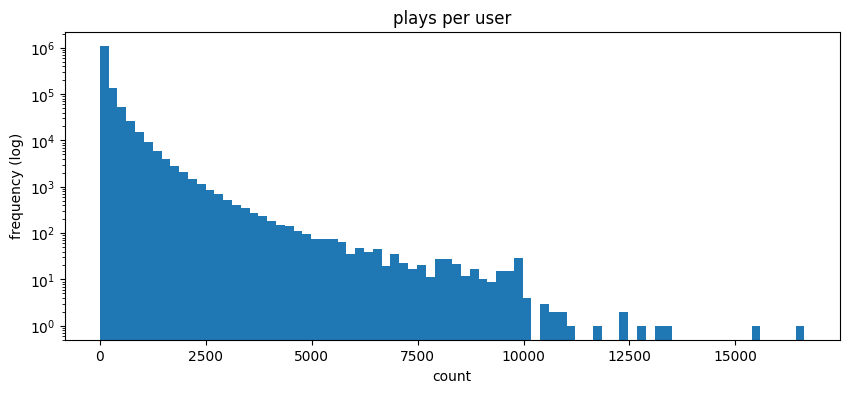


plays per track:
count    980977.000000
mean        226.493026
std        1382.786304
min           5.000000
50%          19.000000
90%         311.000000
99%        3961.000000
max      111062.000000
Name: count, dtype: float64


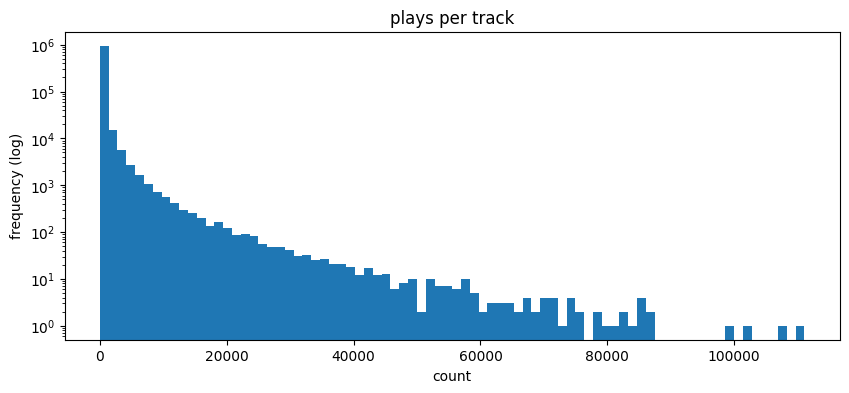

In [14]:
plays_per_user = events_clean["user_id"].value_counts(sort=False)
plays_per_track = events_clean["track_id"].value_counts(sort=False)

plot_distribution(plays_per_user, "plays per user")
plot_distribution(plays_per_track, "plays per track")

In [15]:
users_count = int(plays_per_user.size)
tracks_count = int(plays_per_track.size)
events_count = int(len(events_clean))
sparsity = 1.0 - (events_count / float(users_count * tracks_count))

print(f"users: {users_count:,}")
print(f"tracks: {tracks_count:,}")
print(f"events: {events_count:,}")
print(f"sparsity: {sparsity:.6f}")

users: 1,372,767
tracks: 980,977
events: 222,184,449
sparsity: 0.999835


Наиболее популярные треки

In [16]:
track_names = (
    catalog_names_clean.loc[catalog_names_clean["type"] == "track", ["id", "name"]]
    .rename(columns={"id": "track_id", "name": "track_name"})
)

top_tracks = (
    plays_per_track.sort_values(ascending=False)
    .head(TOP_10)
    .rename_axis("track_id")
    .reset_index(name="plays")
    .merge(track_names, on="track_id", how="left")
)

display(top_tracks)

,track_id,plays,track_name
0,53404,111062,Smells Like Teen Spirit
1,33311009,106921,Believer
2,178529,101924,Numb
3,35505245,99490,I Got Love
4,65851540,86670,Юность
5,24692821,86246,Way Down We Go
6,32947997,85886,Shape of You
7,51241318,85244,In The End
8,795836,85042,Shape Of My Heart
9,45499814,84748,Life


Наиболее популярные жанры

In [17]:

genre_names = (
    catalog_names_clean.loc[catalog_names_clean["type"] == "genre", ["id", "name"]]
    .rename(columns={"id": "genre_id", "name": "genre_name"})
)

tracks_genres = tracks_clean[["track_id", "genres"]].explode("genres").rename(columns={"genres": "genre_id"})
tracks_genres["genre_id"] = tracks_genres["genre_id"].astype(np.int64)

track_plays = plays_per_track.rename_axis("track_id").reset_index(name="plays")
top_genres = (
    tracks_genres.merge(track_plays, on="track_id", how="left")
    .groupby("genre_id", sort=False)["plays"].sum()
    .sort_values(ascending=False)
    .head(TOP_10)
    .rename_axis("genre_id")
    .reset_index(name="plays")
    .merge(genre_names, on="genre_id", how="left")
)

display(top_genres)

,genre_id,plays,genre_name
0,11,55578305,pop
1,75,37799821,rap
2,102,31091989,allrock
3,20,26626234,ruspop
4,3,25303695,rusrap
5,68,20120694,electronics
6,16,16291557,dance
7,2,13166147,rusrock
8,14,12772620,rock
9,47,12437375,metal


Треки, которые никто не прослушал

In [18]:
unheard_count = int((~tracks_clean["track_id"].isin(plays_per_track.index)).sum())
print(f"unheard: {unheard_count:,} ({unheard_count/len(tracks_clean):.2%})")

unheard: 0 (0.00%)


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [19]:
# save clean datasets and cleanup
items_path = save_to_parquet(tracks_clean, ARTIFACTS_DIR / CLEAN_FILES["items"])
events_path = save_to_parquet(events_clean, ARTIFACTS_DIR / CLEAN_FILES["events"])
names_path = save_to_parquet(catalog_names_clean, ARTIFACTS_DIR / CLEAN_FILES["catalog_names"])

file already exists -> skipping: items.parquet
current file info: items.parquet
  size: 17.80 mb
  timestamp: 2026-01-13 17:18:56
file already exists -> skipping: events.parquet
current file info: events.parquet
  size: 1000.42 mb
  timestamp: 2026-01-13 17:19:19
file already exists -> skipping: catalog_names.parquet
current file info: catalog_names.parquet
  size: 34.47 mb
  timestamp: 2026-01-13 17:19:35


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [20]:
del tracks_raw, catalog_names_raw, events_raw, tracks_clean, events_clean, catalog_names_clean
del plays_per_user, plays_per_track, track_names, top_tracks, genre_names, tracks_genres, track_plays, top_genres
gc.collect()

42039

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [21]:
items = read_cached_or_download(CLEAN_FILES["items"], S3_DATA_PREFIX)
events = read_cached_or_download(CLEAN_FILES["events"], S3_DATA_PREFIX)

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [22]:
events["started_at"] = pd.to_datetime(events["started_at"])

events_train = events.loc[events["started_at"] < SPLIT_DATE].reset_index(drop=True)
events_test = events.loc[events["started_at"] >= SPLIT_DATE].reset_index(drop=True)

test_max_timestamp = events_test["started_at"].max()
eval_start_timestamp = test_max_timestamp - pd.Timedelta(days=TEST_DAYS)

events_eval = events_test.loc[events_test["started_at"] >= eval_start_timestamp, ["user_id", "track_id"]].drop_duplicates()
events_labels = events_test.loc[events_test["started_at"] < eval_start_timestamp, ["user_id", "track_id"]].drop_duplicates()

print(f"train: {len(events_train):,} ({len(events_train)/len(events):.1%})")
print(f"test: {len(events_test):,} ({len(events_test)/len(events):.1%})")
print(f"events_labels: {len(events_labels):,} | events_eval: {len(events_eval):,}")

train: 208,334,360 (93.8%)
test: 13,850,089 (6.2%)
events_labels: 8,319,469 | events_eval: 5,530,620


In [23]:
train_split_path = save_to_parquet(events_train, ARTIFACTS_DIR / SPLIT_FILES["train"])
test_split_path = save_to_parquet(events_test, ARTIFACTS_DIR / SPLIT_FILES["test"])

file already exists -> skipping: events_train.parquet
current file info: events_train.parquet
  size: 937.60 mb
  timestamp: 2026-01-13 17:20:38
file already exists -> skipping: events_test.parquet
current file info: events_test.parquet
  size: 61.58 mb
  timestamp: 2026-01-13 17:20:54


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [24]:
top_popular = (
    events_train.groupby("track_id", sort=False).size()
    .sort_values(ascending=False)
    .head(K)
    .rename("score")
    .reset_index()
)

top_popular["rank"] = np.arange(1, len(top_popular) + 1, dtype=np.int16)
top_popular = top_popular[["track_id", "rank", "score"]]

display(top_popular.head(10))

,track_id,rank,score
0,53404,1,110026
1,33311009,2,101076
2,178529,3,100866
3,35505245,4,95523
4,24692821,5,84153
5,795836,6,83749
6,6705392,7,80608
7,32947997,8,80243
8,37384,9,79512
9,45499814,10,78564


In [25]:
top_popular_path = save_to_parquet(top_popular, ARTIFACTS_DIR / RECS_FILES["top_popular"])
maybe_upload(top_popular_path, S3_RECS_PREFIX, RECS_FILES["top_popular"])

file already exists -> skipping: top_popular.parquet
current file info: top_popular.parquet
  size: 0.00 mb
  timestamp: 2026-01-13 17:20:59


# Персональные

Рассчитаем персональные рекомендации.

In [26]:
user_codes, user_index = pd.factorize(events_train["user_id"], sort=False)
item_codes, item_index = pd.factorize(events_train["track_id"], sort=False)

user_codes = user_codes.astype(np.int32, copy=False)
item_codes = item_codes.astype(np.int32, copy=False)

user_item_matrix = coo_matrix(
    (np.full(len(user_codes), ALS_ALPHA, dtype=np.float32), 
     (user_codes, item_codes)),
    shape=(len(user_index), len(item_index)),
    dtype=np.float32,
).tocsr()

user_item_matrix.sum_duplicates()
user_item_matrix.sort_indices()

del user_codes, item_codes
gc.collect()

0

In [27]:
MODEL_PATH = ARTIFACTS_DIR / "als_model.pkl"

if MODEL_PATH.exists():
    print("upload saved ALS model...")
    als_model = AlternatingLeastSquares.load(str(MODEL_PATH))
else:
    print("model learning...")
    als_model = AlternatingLeastSquares(
        factors=ALS_FACTORS,
        regularization=ALS_REGULARIZATION,
        iterations=ALS_ITERATIONS,
        random_state=SEED,
        num_threads=os.cpu_count() or 4,
    )
    als_model.fit(user_item_matrix)
    als_model.save(str(MODEL_PATH))
    print(f"model saved: {MODEL_PATH}")

model learning...


/home/mle-user/mle_projects/mle-project-sprint-4-v001/.venv-recsys/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

model saved: artifacts/als_model.pkl


In [28]:
def personal_recs_batches() -> Iterable[pd.DataFrame]:
    users_total = len(user_index)
    for batch_start in range(0, users_total, ALS_BATCH_USERS):
        batch_end = min(batch_start + ALS_BATCH_USERS, users_total)
        batch_user_ids = np.arange(batch_start, batch_end, dtype=np.int32)

        item_ids, scores = als_model.recommend(
            userid=batch_user_ids,
            user_items=user_item_matrix[batch_start:batch_end],
            N=K,
            filter_already_liked_items=True,
        )

        recommended_item_counts[:] += np.bincount(item_ids.ravel(), minlength=len(item_index)).astype(np.int32, copy=False)

        yield pd.DataFrame(
            {
                "user_id": np.repeat(user_index[batch_start:batch_end], K),
                "track_id": item_index[item_ids.ravel()],
                "rank": np.tile(ranks_template, batch_end - batch_start),
                "score": scores.astype(np.float32, copy=False).ravel(),
            }
        )

In [29]:
personal_path = save_to_parquet(personal_recs_batches(), ARTIFACTS_DIR / RECS_FILES["personal_als"])
print(f"users: {len(user_index):,} | items: {len(item_index):,}")

file already exists -> skipping: personal_als.parquet
current file info: personal_als.parquet
  size: 1065.04 mb
  timestamp: 2026-01-13 18:27:38
users: 1,342,107 | items: 980,684


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [30]:
top_n_sources = min(SIMILAR_TOP_N, len(item_index))
recommended_item_counts = user_item_matrix.getnnz(axis=0).astype(np.int64, copy=False)
source_item_indices = np.argpartition(-recommended_item_counts, top_n_sources - 1)[:top_n_sources].astype(np.int32, copy=False)
item_index_array = np.asarray(item_index, dtype=np.int64)

In [31]:
def similar_recs_batches() -> Iterable[pd.DataFrame]:
    neighbors_count = min(K + 1, len(item_index))
    for batch_start in range(0, len(source_item_indices), SIMILAR_BATCH):
        batch_end = min(batch_start + SIMILAR_BATCH, len(source_item_indices))
        batch_indices = source_item_indices[batch_start:batch_end]

        similar_ids, scores = als_model.similar_items(itemid=batch_indices, N=neighbors_count)
        similar_ids = similar_ids[:, 1:K + 1]
        scores = scores[:, 1:K + 1]

        yield pd.DataFrame(
            {
                "track_id": np.repeat(item_index_array[batch_indices], K),
                "similar_track_id": item_index_array[similar_ids.ravel()],
                "rank": np.tile(ranks_template, batch_end - batch_start),
                "score": scores.astype(np.float32, copy=False).ravel(),
            }
        )

In [32]:
similar_path = save_to_parquet(similar_recs_batches(), ARTIFACTS_DIR / RECS_FILES["similar"])

del source_item_indices
gc.collect()

file already exists -> skipping: similar.parquet
current file info: similar.parquet
  size: 18.13 mb
  timestamp: 2026-01-13 18:28:57


18

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [33]:
track_popularity = events_train["track_id"].value_counts(sort=False).astype(np.int32)
user_activity = events_train["user_id"].value_counts(sort=False).astype(np.int32)
track_novelty = (int(track_popularity.max()) - track_popularity).astype(np.int32)

track_genre_counts = items.set_index("track_id")["genres"].map(len).astype(np.int16)
track_artist_counts = items.set_index("track_id")["artists"].map(len).astype(np.int16)

def feature_batches() -> Iterable[pd.DataFrame]:
    parquet_file = pq.ParquetFile(str(personal_path))
    for record_batch in parquet_file.iter_batches(columns=["user_id", "track_id", "rank", "score"], batch_size=ALS_BATCH_USERS * K):
        batch_df = record_batch.to_pandas()

        batch_df["track_popularity"] = track_popularity.reindex(batch_df["track_id"]).fillna(0).to_numpy(dtype=np.int32, copy=False)
        batch_df["user_activity"] = user_activity.reindex(batch_df["user_id"]).fillna(0).to_numpy(dtype=np.int32, copy=False)
        batch_df["track_novelty"] = track_novelty.reindex(batch_df["track_id"]).fillna(int(track_popularity.max())).to_numpy(dtype=np.int32, copy=False)
        batch_df["num_genres"] = track_genre_counts.reindex(batch_df["track_id"]).fillna(0).to_numpy(dtype=np.int16, copy=False)
        batch_df["num_artists"] = track_artist_counts.reindex(batch_df["track_id"]).fillna(0).to_numpy(dtype=np.int16, copy=False)

        batch_df["rank"] = batch_df["rank"].to_numpy(dtype=np.int16, copy=False)
        batch_df["score"] = batch_df["score"].to_numpy(dtype=np.float32, copy=False)

        yield batch_df[["user_id", "track_id", "rank", "score", "track_popularity", "user_activity", "track_novelty", "num_genres", "num_artists"]]

In [34]:
features_path = save_to_parquet(feature_batches(), ARTIFACTS_DIR / "personal_als_features.parquet")

del user_activity, track_novelty, track_genre_counts, track_artist_counts
gc.collect()

file already exists -> skipping: personal_als_features.parquet
current file info: personal_als_features.parquet
  size: 2193.63 mb
  timestamp: 2026-01-13 19:55:44


0

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [35]:
feature_names = ["score", "rank", "track_popularity", "user_activity", "track_novelty", "num_genres", "num_artists"]
read_cols = ["user_id", "track_id"] + feature_names

pf = pq.ParquetFile(str(features_path))
user_pool = set()
need_pool = TRAIN_USERS * POOL_MULT

for rb in pf.iter_batches(columns=["user_id"], batch_size=BATCH_ROWS):
    user_pool.update(np.unique(rb.column(0).to_numpy(zero_copy_only=False)).astype(np.uint32))
    if len(user_pool) >= need_pool:
        break

user_pool_arr = np.fromiter(user_pool, dtype=np.uint32)
rng = np.random.default_rng(SEED)
sample_users = rng.choice(user_pool_arr, size=min(TRAIN_USERS, user_pool_arr.size), replace=False).astype(np.uint32, copy=False)
sample_users.sort()

del user_pool, user_pool_arr, pf
gc.collect()

print(f"sampled users: {sample_users.size:,}")

sampled users: 80,000


In [36]:
pos_keys = np.empty(0, dtype=np.uint64)

for start in range(0, len(events_labels), POS_CHUNK):
    chunk = events_labels.iloc[start : start + POS_CHUNK]
    chunk_users = chunk["user_id"].to_numpy(dtype=np.uint32, copy=False)

    idx = np.searchsorted(sample_users, chunk_users)
    mask = (idx < sample_users.size)
    mask[mask] &= (sample_users[idx[mask]] == chunk_users[mask])


    chunk_tracks = chunk["track_id"].to_numpy(dtype=np.uint32, copy=False)
    keys = (chunk_users[mask].astype(np.uint64, copy=False) << 32) | chunk_tracks[mask].astype(np.uint64, copy=False)
    pos_keys = np.union1d(pos_keys, np.unique(keys))

del events_labels
gc.collect()

print(f"positive pairs (sampled): {pos_keys.size:,}")

positive pairs (sampled): 475,910


In [37]:
pf = pq.ParquetFile(str(features_path))
X_parts, y_parts, u_parts = [], [], []
rows = 0

for rb in pf.iter_batches(columns=read_cols, batch_size=BATCH_ROWS):
    users = rb.column("user_id").to_numpy(zero_copy_only=False).astype(np.uint32, copy=False)

    idx = np.searchsorted(sample_users, users)
    mask = (idx < sample_users.size) & (sample_users[idx] == users)
    if not mask.any():
        continue

    users = users[mask]
    tracks = rb.column("track_id").to_numpy(zero_copy_only=False).astype(np.uint32, copy=False)[mask]
    keys = (users.astype(np.uint64, copy=False) << 32) | tracks.astype(np.uint64, copy=False)

    if pos_keys.size:
        j = np.searchsorted(pos_keys, keys)
        hits = (j < pos_keys.size) & (pos_keys[j] == keys)
    else:
        hits = np.zeros(keys.size, dtype=bool)

    feats = np.column_stack([rb.column(c).to_numpy(zero_copy_only=False)[mask] for c in feature_names]).astype(np.float32, copy=False)

    X_parts.append(feats)
    y_parts.append(hits.astype(np.int8, copy=False))
    u_parts.append(users)

    rows += users.size
    if rows >= TRAIN_ROWS_LIMIT:
        break

del pf
gc.collect()

X = np.concatenate(X_parts, axis=0)
y = np.concatenate(y_parts, axis=0)
users = np.concatenate(u_parts, axis=0)

del X_parts, y_parts, u_parts
gc.collect()

# trim last incomplete user group (если мы оборвали чтение посередине пользователя)
bounds = np.flatnonzero(np.r_[True, users[1:] != users[:-1], True])
group_sizes = np.diff(bounds)
if group_sizes.size and group_sizes[-1] != K:
    cut = bounds[-2]
    X, y, users = X[:cut], y[:cut], users[:cut]
    bounds = bounds[:-1]
    group_sizes = group_sizes[:-1]

# sanity: fast path assumes fixed K candidates per user
if group_sizes.size == 0 or group_sizes.min() != K or group_sizes.max() != K:
    raise ValueError("features_path must be sorted by user_id and each user must have exactly K candidates (fixed).")

print(f"train rows: {X.shape[0]:,} | target rate: {y.mean():.4f}")
print(f"ram: {psutil.virtual_memory().available / 1024**3:.2f} gb")

train rows: 1,265,200 | target rate: 0.0034
ram: 17.22 gb


In [38]:
uniq_users = np.unique(users)
rng.shuffle(uniq_users)
split = int(0.8 * uniq_users.size)
train_user_ids = np.sort(uniq_users[:split].astype(np.uint32, copy=False))

pos = np.searchsorted(train_user_ids, users)
train_mask = (pos < train_user_ids.size) & (train_user_ids[pos] == users)
val_mask = ~train_mask

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]

# groups are fixed K, and arrays stay user-sorted after masking
if (X_train.shape[0] % K) or (X_val.shape[0] % K):
    raise ValueError("Train/val rows must be divisible by K. Check that users are not split and K is correct.")

group_train = np.full(X_train.shape[0] // K, K, dtype=np.int32)
group_val = np.full(X_val.shape[0] // K, K, dtype=np.int32)

del X, y, users, uniq_users, train_user_ids, pos, train_mask, val_mask
gc.collect()

0

In [39]:
print("\ntraining LGBMRanker...")
ranker = lgb.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=63,
    random_state=SEED,
    n_jobs=-1,
    verbosity=-1,
)

ranker.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)],
)

best_iter = int(getattr(ranker, "best_iteration_", 0) or 0) or None

del X_train, y_train, group_train, X_val, y_val, group_val
gc.collect()

print(f"best_iteration: {best_iter}")
print(f"ram: {psutil.virtual_memory().available / 1024**3:.2f} gb")


training LGBMRanker...
best_iteration: 38
ram: 17.20 gb


In [40]:
print("\nreranking (streaming) ...")

output_path = ARTIFACTS_DIR / RECS_FILES["ranked"]
output_path.parent.mkdir(parents=True, exist_ok=True)

pf = pq.ParquetFile(str(features_path))
writer = None
written = 0
rank_template = np.arange(1, TOP_10 + 1, dtype=np.int16)

tail_users = tail_tracks = tail_feats = None

for i, rb in enumerate(pf.iter_batches(columns=read_cols, batch_size=BATCH_ROWS)):
    users = rb.column("user_id").to_numpy(zero_copy_only=False).astype(np.uint32, copy=False)
    tracks = rb.column("track_id").to_numpy(zero_copy_only=False).astype(np.uint32, copy=False)
    feats = np.column_stack([rb.column(c).to_numpy(zero_copy_only=False) for c in feature_names]).astype(np.float32, copy=False)

    if tail_users is not None:
        users = np.concatenate([tail_users, users])
        tracks = np.concatenate([tail_tracks, tracks])
        feats = np.vstack([tail_feats, feats])
        tail_users = tail_tracks = tail_feats = None

    if users.size == 0:
        continue

    last_user = users[-1]
    not_last = users != last_user
    if not not_last.any():
        tail_users, tail_tracks, tail_feats = users, tracks, feats
        continue

    cut = np.flatnonzero(not_last)[-1] + 1
    users_c, tracks_c, feats_c = users[:cut], tracks[:cut], feats[:cut]
    tail_users, tail_tracks, tail_feats = users[cut:], tracks[cut:], feats[cut:]

    usable = (users_c.size // K) * K
    if usable == 0:
        tail_users = np.concatenate([users_c, tail_users])
        tail_tracks = np.concatenate([tracks_c, tail_tracks])
        tail_feats = np.vstack([feats_c, tail_feats])
        continue

    if usable < users_c.size:
        tail_users = np.concatenate([users_c[usable:], tail_users])
        tail_tracks = np.concatenate([tracks_c[usable:], tail_tracks])
        tail_feats = np.vstack([feats_c[usable:], tail_feats])
        users_c, tracks_c, feats_c = users_c[:usable], tracks_c[:usable], feats_c[:usable]

    scores = ranker.predict(feats_c, num_iteration=best_iter).astype(np.float32, copy=False)

    n_users = usable // K
    tracks_m = tracks_c.reshape(n_users, K)
    scores_m = scores.reshape(n_users, K)

    top_idx = np.argpartition(-scores_m, kth=TOP_10 - 1, axis=1)[:, :TOP_10]
    top_scores = np.take_along_axis(scores_m, top_idx, axis=1)
    top_idx = np.take_along_axis(top_idx, np.argsort(-top_scores, axis=1), axis=1)

    rows = np.arange(n_users)[:, None]
    out_users = np.repeat(users_c[::K].astype(np.uint32, copy=False), TOP_10)
    out_tracks = tracks_m[rows, top_idx].ravel().astype(np.uint32, copy=False)
    out_scores = scores_m[rows, top_idx].ravel().astype(np.float32, copy=False)
    out_ranks = np.tile(rank_template, n_users)

    table = pa.Table.from_pydict({"user_id": out_users, "track_id": out_tracks, "rank": out_ranks, "score": out_scores})

    if writer is None:
        writer = pq.ParquetWriter(str(output_path), table.schema, compression="snappy", use_dictionary=False, write_statistics=False)

    writer.write_table(table, row_group_size=1_000_000)
    written += int(out_users.size)

    if (i + 1) % 25 == 0:
        gc.collect()

# flush tail (последний пользователь)
if tail_users is not None and tail_users.size:
    if tail_users.size % K != 0:
        raise ValueError("Tail size is not divisible by K -> features_path is likely not fixed-K or not sorted.")
    scores = ranker.predict(tail_feats, num_iteration=best_iter).astype(np.float32, copy=False)
    n_users = tail_users.size // K

    tracks_m = tail_tracks.reshape(n_users, K)
    scores_m = scores.reshape(n_users, K)

    top_idx = np.argpartition(-scores_m, kth=TOP_10 - 1, axis=1)[:, :TOP_10]
    top_scores = np.take_along_axis(scores_m, top_idx, axis=1)
    top_idx = np.take_along_axis(top_idx, np.argsort(-top_scores, axis=1), axis=1)

    rows = np.arange(n_users)[:, None]
    out_users = np.repeat(tail_users[::K].astype(np.uint32, copy=False), TOP_10)
    out_tracks = tracks_m[rows, top_idx].ravel().astype(np.uint32, copy=False)
    out_scores = scores_m[rows, top_idx].ravel().astype(np.float32, copy=False)
    out_ranks = np.tile(rank_template, n_users)

    table = pa.Table.from_pydict({"user_id": out_users, "track_id": out_tracks, "rank": out_ranks, "score": out_scores})

    if writer is None:
        writer = pq.ParquetWriter(str(output_path), table.schema, compression="snappy", use_dictionary=False, write_statistics=False)

    writer.write_table(table, row_group_size=1_000_000)
    written += int(out_users.size)

if writer is not None:
    writer.close()

gc.collect()

print(f"written: {written:,} rows")
print(f"saved: {output_path}")
print(f"final ram: {psutil.virtual_memory().available / 1024**3:.2f} gb")


reranking (streaming) ...


written: 13,421,070 rows
saved: artifacts/recommendations.parquet
final ram: 17.09 gb


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [41]:
# UPLOAD TO S3

# upload_to_s3(personal_path, make_s3_key(S3_RECS_PREFIX, RECS_FILES["personal_als"]))
# upload_to_s3(similar_path, make_s3_key(S3_RECS_PREFIX, RECS_FILES["similar"]))
# upload_to_s3(features_path, make_s3_key(S3_RECS_PREFIX, "personal_als_features.parquet"))

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [48]:
recommendations = pd.read_parquet(ARTIFACTS_DIR / RECS_FILES["ranked"])

def calculate_metrics(
    recs: pd.DataFrame,
    test: pd.DataFrame,
    catalog_size: int,
    item_pop: pd.Series,
    k: int = 10,
) -> dict:
    top_k = (
        recs[["user_id", "track_id", "rank"]]
        .groupby("user_id", sort=False)
        .head(k)[["user_id", "track_id"]]
        .drop_duplicates()
    )

    gt = test[["user_id", "track_id"]].drop_duplicates()

    hits = top_k.merge(gt, on=["user_id", "track_id"], how="inner")

    h = hits.groupby("user_id", sort=False).size()
    r = top_k.groupby("user_id", sort=False).size()
    rel = gt.groupby("user_id", sort=False).size()

    common = r.index.intersection(rel.index)
    if common.empty:
        return {"precision@k": 0.0, "recall@k": 0.0, "coverage": 0.0, "novelty": 0.0}

    hits_v = h.reindex(common, fill_value=0).to_numpy(np.float32)
    recs_v = r.reindex(common).to_numpy(np.float32)
    rel_v = rel.reindex(common).to_numpy(np.float32)

    precision = np.mean(hits_v / recs_v)
    recall = np.mean(hits_v / rel_v)

    coverage = top_k["track_id"].nunique() / catalog_size

    pop_v = item_pop.reindex(top_k["track_id"], fill_value=0).to_numpy(np.float32)
    novelty = np.mean(1.0 / (1.0 + pop_v))

    return {
        "precision@k": float(precision),
        "recall@k": float(recall),
        "coverage": float(coverage),
        "novelty": float(novelty),
    }

In [51]:
def metrics_top_popular(
    top_tracks: np.ndarray,
    test: pd.DataFrame,
    catalog_size: int,
    item_pop: pd.Series,
    k: int = 10,
) -> dict:
    test_users = test["user_id"].unique()
    n_users = min(1000, len(test_users))
    sample_users = np.random.choice(test_users, size=n_users, replace=False)

    recs_fake = pd.DataFrame({
        "user_id": np.repeat(sample_users, k),
        "track_id": np.tile(top_tracks[:k], n_users)
    }).drop_duplicates()

    gt = test[test["user_id"].isin(sample_users)][["user_id", "track_id"]].drop_duplicates()

    hits = recs_fake.merge(gt, on=["user_id", "track_id"], how="inner")

    h = hits.groupby("user_id", sort=False).size()
    r = recs_fake.groupby("user_id", sort=False).size()
    rel = gt.groupby("user_id", sort=False).size()

    common = r.index.intersection(rel.index)
    if common.empty:
        return {"precision@k": 0.0, "recall@k": 0.0, "coverage": 0.0, "novelty": 0.0}

    hits_v = h.reindex(common, fill_value=0).to_numpy(np.float32)
    recs_v = r.reindex(common).to_numpy(np.float32)
    rel_v = rel.reindex(common).to_numpy(np.float32)

    precision = np.mean(hits_v / recs_v)
    recall = np.mean(hits_v / rel_v)

    coverage = recs_fake["track_id"].nunique() / catalog_size

    pop_v = item_pop.reindex(recs_fake["track_id"], fill_value=0).to_numpy(np.float32)
    novelty = np.mean(1.0 / (1.0 + pop_v))

    return {
        "precision@k": float(precision),
        "recall@k": float(recall),
        "coverage": float(coverage),
        "novelty": float(novelty),
    }

In [52]:
all_items_count = int(items["track_id"].nunique())
item_popularity = track_popularity

print("\n=== TOP POPULAR ===")
top_tracks = top_popular["track_id"].to_numpy(copy=False)[:TOP_10]
metrics_popular = metrics_top_popular(top_tracks, events_test, all_items_count, item_popularity, k=TOP_10)
for m, v in metrics_popular.items():
    print(f"{m}: {v:.4f}")

print("\n=== PERSONAL ALS ===")
personal_als = read_parquet(personal_path)
metrics_als = calculate_metrics(personal_als, events_test, all_items_count, item_popularity, k=TOP_10)
for m, v in metrics_als.items():
    print(f"{m}: {v:.4f}")

print("\n=== RECOMMENDATIONS (RANKED) ===")
metrics_final = calculate_metrics(recommendations, events_test, all_items_count, item_popularity, k=TOP_10)
for m, v in metrics_final.items():
    print(f"{m}: {v:.4f}")

comparison = pd.DataFrame({
    "model": ["top_popular", "personal_als", "ranked"],
    **{m: [metrics_popular[m], metrics_als[m], metrics_final[m]] for m in metrics_popular}
})
display(comparison)


=== TOP POPULAR ===
precision@k: 0.0035
recall@k: 0.0046
coverage: 0.0000
novelty: 0.0000

=== PERSONAL ALS ===
precision@k: 0.0117
recall@k: 0.0184
coverage: 0.0335
novelty: 0.0001

=== RECOMMENDATIONS (RANKED) ===
precision@k: 0.0164
recall@k: 0.0240
coverage: 0.0461
novelty: 0.0001


,model,precision@k,recall@k,coverage,novelty
0,top_popular,0.003500,0.004636,0.000010,0.000011
1,personal_als,0.011659,0.018391,0.033533,0.000076
2,ranked,0.016388,0.024025,0.046117,0.000142
